# Examen Projet NLP TALA540A 

## Auteurs :
- AROUN Jeevya
- NGAUV Nicolas
- THEZENAS Anissa

In [1]:
import sys
import csv
import json
import re
from dataclasses import dataclass, field, asdict
from typing import List

In [13]:
@dataclass
class Review:
    id: int
    content: str
    gender: str

@dataclass
class FragranceData:
    reviews: List[Review] = field(default_factory=list)

    def add_review(self, review: Review):
        self.reviews.append(review)

In [14]:
def extract_gender(title: str) -> str:
    """extraire le genre du titre du parfum"""
    title = title.lower().strip()
    if title.endswith("for men"):
        return "male"
    elif title.endswith("for women"):
        return "female"
    elif title.endswith("for women and men"):
        return "unisex"
    else:
        return "unknown"

def clean_review(text: str) -> str:
    """masquer les mots clé de genre dans les reviews"""
    text = text.lower()
    gendered_words = ["for men", "for women", "unisex", "pour homme", "pour femme", "male", "female", "man", "woman", "boy", "girl"]
    for word in gendered_words:
        text = re.sub(r'\b' + word + r'\b', "[MASK]", text)
    return text

def process_csv(file_path: str, output_json: str) -> None:
    """process CSV -> JSON output"""
    fragrance_data = FragranceData()
    
    with open(file_path, mode="r", encoding="utf-8") as csv_file:
        reader = csv.DictReader(csv_file)
        review_id = 1  
        
        for row in reader:
            #prendre les champs nécessaires
            title = row.get("title", "")
            reviews = row.get("reviews", "[]")
            reviews = eval(reviews) if reviews else []
            
            #déterminer le genre en fonction du titre
            gender = extract_gender(title)
            
            for review_text in reviews:
                if review_text:
                    #nettoyer et masquer les mots clés de genre
                    cleaned_text = clean_review(review_text)
                    review = Review(id=review_id, content=cleaned_text, gender=gender)
                    fragrance_data.add_review(review)
                    review_id += 1  #incrémenter le compteur pour id
    
    #écrire le fichier au format JSON
    with open(output_json, mode="w", encoding="utf-8") as json_file:
        json.dump([asdict(review) for review in fragrance_data.reviews], json_file, indent=2, ensure_ascii=False)


In [15]:
#augmenter la taille limite du csv
csv.field_size_limit(sys.maxsize)
#process le csv pour obtenir le fichier clean en JSON
csv_file_path = "../data/raw/perfumes_table.csv"
output_json_path = "../data/clean/cleaned_data.json"
process_csv(csv_file_path, output_json_path)

### Description du dataset

#### Type de données, taille, prétraitement effectué (ex. : tokenisation, lemmatisation, suppression des stopwords, etc.)
    - Type de données : 
        - dataset obtenu sur Kaggle, et issu du web-scraping du site Fragantica en été 2023, présenté dans un fichier au format CSV
        - on y trouve des informations sur 84 144 parfums répertoriés sur Fragantica 
        - pour chaque parfum, on a les informations suivantes :
            - la moyenne des notes (sur 5) que peuvent données les utilisateurs de Fragantica,
            - les fragrances ou notes olfactives,
            - la marque,
            - les commentaires que les utilisateurs ont laissé,
            - la description du parfum qu'on retrouve sur la page web,
            - l'URL de la page web,
            - le titre de la page web
            
    - Taille : 690,8 Mio avant prétraitement et 768,3 Mio après
    
    - Prétraitement effectué, on a un fichier JSON avec : 
        - nettoyage des données (suppression des informations inutiles)
        - extraction du nom et du genre à partir du titre de la page pour chaque parfum et création de ces colonnes et ajout au dataset pour faciliter la suite du travail
        - après traitement on a donc pour chaque commentaire :
            - l'ID (int),
            - le commentaire (contenu textuel donc chaine de caractères),
            - le genre du public visé du parfum sur lequel le commentaire a été laissé ('unisex, 'male', female')


#### Description statistique (distribution des classes, fréquence des mots, longueur moyenne des commentaires, etc.) et qualitative (exemples typiques, difficultés linguistiques, caractéristiques particulières) : juste en dessous

In [21]:
#visualisation graphique de la distribution des reviews
import json
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from typing import List, Dict
import nltk
import numpy as np

#ouvrir le json clean
def load_data(json_path: str):
    with open(json_path, mode="r", encoding="utf-8") as file:
        data = json.load(file)
    return data

def get_gender_distribution(data: List[dict]) -> Counter:
    genders = [review["gender"] for review in data]
    return Counter(genders)

#review lengths in nb of tokens
def get_review_lengths(data: List[dict]) -> List[int]:
    review_lengths = []
    for review in data:
        content = review["content"]
        tokens = nltk.word_tokenize(content)
        review_lengths.append(len(tokens))
    return review_lengths

def plot_gender_distribution(gender_counts: Counter, output_path):
    labels = gender_counts.keys()
    values = gender_counts.values()

    plt.figure(figsize=(8, 6))
    sns.barplot(x=list(labels), y=list(values), palette="viridis")
    plt.xlabel("Gender Category")
    plt.ylabel("Number of Reviews")
    plt.title("Distribution of Gender Categories (Men, Women, Unisex)")
    plt.savefig(output_path)
    plt.show()


/var/folders/my/cpx2yr615539_gmrd12j8xw80000gn/T/ipykernel_51848/4280196646.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(labels), y=list(values), palette="viridis")


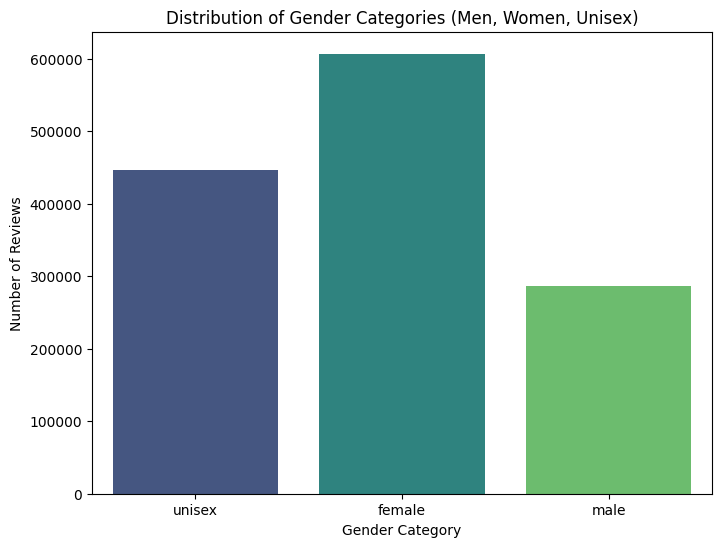

In [22]:
data = load_data("../data/clean/cleaned_data.json")
gender_counts = get_gender_distribution(data)
plot_gender_distribution(gender_counts, "../plots/gender_distribution.png")

### Nettoyage du JSON
Suppression des reviews de moins de 10 tokens soit une phrase. 

In [ ]:
import json

with open("../data/clean/cleaned_data.json", "r") as file:
    data = json.load(file)

# Fonction pour compter le nombre de tokens (mots) dans une phrase
def token_count(review):
    return len(review.split())

# Filtrer les avis avec au moins 10 tokens
cleaned_data = [item for item in data if token_count(item["content"]) >= 10]

# Enregistrer le JSON nettoyé
with open("../data/clean/perfume_reviews_cleaned.json", "w") as file:
    json.dump(cleaned_data, file, indent=4)

print(f"Nettoyage terminé. Nombre d'entrées restantes : {len(cleaned_data)}")

### Equilibrage du Dataset 
Notre objectif est donc de rééquilibrer le dataset afin que chaque classe (male, female, unisex dans ce cas) ait le même nombre d’exemples. Cela permet au modèle d’apprendre de manière égale sur chaque genre, améliorant ainsi sa capacité à faire des prédictions justes pour chaque catégorie.


In [ ]:
import json
from collections import Counter
import random

# Charger le fichier JSON nettoyé
with open("../data/clean/perfume_reviews_cleaned.json", "r") as file:
    data = json.load(file)

# Compter le nombre d'entrées pour chaque genre
gender_counts = Counter(item["gender"] for item in data)
print("Nombre d'entrées par genre avant équilibrage:", gender_counts)

# Déterminer la taille minimale (nombre d'entrées pour 'male')
min_count = gender_counts["male"]

# Créer des sous-échantillons pour chaque genre
balanced_data = []
for gender in gender_counts:
    # Filtrer les avis par genre
    entries = [item for item in data if item["gender"] == gender]
    # Si le nombre d'entrées est supérieur au minimum, réduire aléatoirement
    if len(entries) > min_count:
        entries = random.sample(entries, min_count)
    balanced_data.extend(entries)

# Mélanger les données pour éviter tout ordre prévisible
random.shuffle(balanced_data)

# Sauvegarder le dataset équilibré
with open("perfume_reviews_balanced.json", "w") as file:
    json.dump(balanced_data, file, indent=4)

print("Équilibrage terminé. Nombre d'entrées par genre après équilibrage:")
print(Counter(item["gender"] for item in balanced_data))

##  Présentation de l'outil

SVM

Présentation de l'outil : Support Vector Machine (SVM)
Description et Fonctionnalités

La machine à vecteurs de support (SVM) est un algorithme de classification supervisée qui cherche à trouver un hyperplan optimal séparant les classes de données, maximisant ainsi la marge entre les données des différentes classes. Dans les tâches de traitement de texte, comme la classification de commentaires de produits en fonction du genre du parfum, SVM est particulièrement utile pour sa capacité à gérer des données de haute dimension, caractéristiques des représentations textuelles.

Fonctionnalités principales :

    Classification binaire et multiclasse : SVM peut être utilisé pour des problèmes de classification à deux classes (comme "masculin" vs "féminin") ou avec plusieurs classes (par exemple, "masculin", "féminin", "unisex").
    Support de noyaux personnalisés : Pour les données complexes, SVM utilise des fonctions de noyau pour projeter les données dans un espace de dimension supérieure où elles deviennent séparables. Les noyaux les plus courants sont le noyau linéaire, le noyau radial (RBF), et le noyau polynomial.
    Paramètre C : Ce paramètre de régularisation permet de gérer le compromis entre maximisation de la marge et minimisation des erreurs de classification.
    Robustesse aux données bruitées : Le modèle peut ignorer certains points de données mal classés si cela permet d'obtenir une meilleure séparation des classes globales.

Configuration et Prétraitement des Données

Pour une tâche de classification de texte comme celle-ci, il est nécessaire de transformer les données textuelles en une représentation numérique. Les techniques courantes sont :

    TF-IDF (Term Frequency - Inverse Document Frequency) : Cette méthode calcule une valeur pour chaque mot dans chaque document, en fonction de sa fréquence et de sa rareté dans l'ensemble des documents. Cela permet de pondérer les mots importants pour chaque document.
    Word Embeddings : Utiliser des vecteurs d'incorporation comme Word2Vec ou GloVe pour représenter chaque mot. Bien que ces méthodes soient plus complexes, elles capturent mieux la sémantique, mais pour un premier modèle, TF-IDF est souvent efficace et rapide à implémenter.
    Nettoyage des données textuelles : Enlever les stopwords, lemmatiser les mots pour réduire les variations morphologiques, et nettoyer les données inutiles (caractères spéciaux, ponctuation, etc.).

Avantages pour la classification des commentaires

    Robustesse dans les espaces de grande dimension : SVM est très adapté pour les tâches de traitement de texte, où chaque mot ou ensemble de mots peut constituer une dimension.
    Flexibilité : Grâce aux noyaux, SVM peut adapter ses frontières de décision à des données textuelles non linéaires.
    Adapté aux classes déséquilibrées : Le paramètre de régularisation C permet d'ajuster la tolérance aux erreurs, utile si certains genres sont moins représentés que d'autres.

Inconvénients pour la tâche

    Complexité computationnelle : SVM peut être coûteux en ressources pour de très grands ensembles de données comme celui-ci, bien qu'il reste performant pour des sous-ensembles de données ou après une réduction dimensionnelle.
    Sensibilité aux paramètres : Les performances de SVM dépendent des choix de noyau, C, et gamma, ce qui nécessite souvent de nombreux essais pour obtenir une bonne configuration.
    Interprétabilité : Contrairement aux modèles de régression logistique ou aux arbres de décision, SVM est moins interprétable, surtout avec des noyaux non linéaires.

Justification du Choix de SVM pour la Classification des Commentaires de Parfums

SVM a été choisi en raison de son efficacité dans les tâches de classification de texte et sa capacité à séparer des classes qui peuvent être non linéaires, un aspect pertinent pour les commentaires de parfums où le vocabulaire peut varier en fonction du genre. Pour la classification de textes courts en genres, le SVM offre un bon compromis entre performance et complexité, tout en restant moins sensible aux variations syntaxiques ou sémantiques que d'autres méthodes.

### SVM

Accuracy: 0.6715
Classification Report:
               precision    recall  f1-score   support

        male       0.71      0.72      0.72      2002
      female       0.70      0.72      0.71      1996
      unisex       0.61      0.57      0.59      2002

    accuracy                           0.67      6000
   macro avg       0.67      0.67      0.67      6000
weighted avg       0.67      0.67      0.67      6000



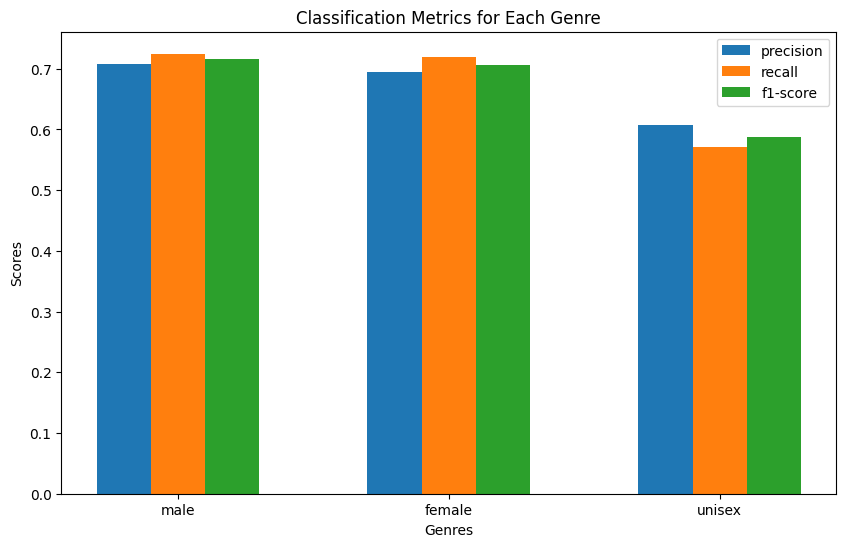

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
import json
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
import random

# Charger les données JSON
with open("../data/clean/perfume_reviews_cleaned.json", "r") as file:
    data = json.load(file)

# Organiser les exemples par genre
gender_mapping = {"male": 0, "female": 1, "unisex": 2}
grouped_data = defaultdict(list)

for item in data:
    if item["gender"] in gender_mapping:
        grouped_data[item["gender"]].append(item)

# Assurer un échantillon équilibré de 10 000 exemples
balanced_data = []
sample_size = 10000  
for gender, items in grouped_data.items():

    balanced_data.extend(random.sample(items, min(sample_size, len(items))))


# Extraire les avis et les genres pour les données équilibrées
reviews = [item["content"] for item in balanced_data]
genders = [item["gender"] for item in balanced_data]
y = [gender_mapping[gender] for gender in genders]

# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(reviews, y, test_size=0.2, random_state=42)

# Vectorisation des avis avec TF-IDF
vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Entraîner le modèle SVM
model = SVC(kernel='linear')
model.fit(X_train_tfidf, y_train)

# Prédire sur les données de test
y_pred = model.predict(X_test_tfidf)

# Évaluer le modèle
print("Accuracy:", accuracy_score(y_test, y_pred))

# Générer le rapport de classification en fonction des classes présentes
present_classes = sorted(set(y_test))  # Obtenir les classes présentes dans y_test
target_names = [list(gender_mapping.keys())[list(gender_mapping.values()).index(i)] for i in present_classes]
report = classification_report(y_test, y_pred, labels=present_classes, target_names=target_names, output_dict=True)
print("Classification Report:\n", classification_report(y_test, y_pred, labels=present_classes, target_names=target_names))

# Visualiser les métriques de chaque classe
metrics = ["precision", "recall", "f1-score"]
x = np.arange(len(target_names))  # Position pour chaque classe
width = 0.2  # Largeur des barres

fig, ax = plt.subplots(figsize=(10, 6))

# Ajouter une barre pour chaque métrique
for i, metric in enumerate(metrics):
    values = [report[cls][metric] for cls in target_names]
    ax.bar(x + i * width, values, width, label=metric)

# Paramétrage des axes et légendes
ax.set_xlabel('Genres')
ax.set_ylabel('Scores')
ax.set_title('Classification Metrics for Each Genre')
ax.set_xticks(x + width)
ax.set_xticklabels(target_names)
ax.legend()

# Afficher le graphique
plt.show()